In this python notebook, we use skmultilearn package as it focuses on multilabel classification. 
We  input the processeed data and use the training set to train the model and examine performance metrics for the test set.

### Multi-label classification strategy
We will use multi-label classification. Before we discuss which classifier to use (ex. KNN, SVM), we should consdier how we will treat the response variable first.

The "strategies" we used is listed below:
1. Binary Relevence(BR)
we seperate each genre into seperate problems (one for each genre).
However, this ignore label dependence. 
Ex. if a movie is tagged as Drama, it is likely that it is also tagged as Action. if a movie is tagged as  Horror, it is likely that it is also tagged as Romance.
If two classes of a genre (Yes/No) have very uneven sizes in the training set, the classifier will lean toward the class with higher movie number.
There is a method called a label correction strategy that can help to improve accuracy
For example, if our prediction is [Y_horror, Y_romance, Y_drama]= [1,1,0], which does not really happen in training set. We find another likely matching vector. We may change our prediction to be [1,0,1].

2. Classifier Chains (CC)
We seperate each genre into seperate problems, but include previous predictions as predictors.
For example, X is our predictor for Y_horror. Next, X, Y_horror are our predictor for Y_romance.
However, error may be propagated down the chain.

3. Label Powerset (LP)
Instead of having seperate Y_i for each genre i, we will predict only Y. Y has 2^I possible values where I is the number of genre.
For example, if Y_horror = 1, Y_romance = 0, Y_drama = 1, Y = [101]
However, imbalance of the data can be an issue.

### Classifier
For each of the strategy, we will then apply different classifier.
1. Naive Bayes
2. KNN
3. Multinomial
4. SVM

### Performance mertic
Please refer to the python notebook "Milestone3_performancemetrics".
In short, we will evaluate majorly based on F1 score and Hamming loss.


In [1]:
import os
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import matplotlib.colors as colors
import math
import seaborn.apionly as sns
import datetime as dt

from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import jaccard_similarity_score

from skmultilearn.problem_transform import BinaryRelevance, LabelPowerset, ClassifierChain
from sklearn.naive_bayes import GaussianNB
from skmultilearn.ensemble.rakeld import RakelD

from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

# classifier
from skmultilearn.adapt import MLkNN
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC

from functools import partial

# cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

%matplotlib inline

In [2]:
dir_python_notebook = os.getcwd()
dir_movie_project = os.path.abspath(os.path.join(dir_python_notebook, os.pardir))
dir_data = os.path.join(dir_movie_project, 'project')

# Global variable

In [3]:
MODELS = {
    "Gaussian Naive Bayes": GaussianNB(),
    #"Random Forest": RandomForestClassifier(random_state=0),
    #"Extra Trees": ExtraTreesClassifier(n_estimators=100, random_state=0),
    "SVM": SVC(),
    "KNN, k=5": KNeighborsClassifier(n_neighbors=5),
    #"KNN, k=10": KNeighborsClassifier(n_neighbors=10),
}


In [4]:
STRATEGIES = {
     'Binary Relevance': BinaryRelevance(),
    'Classifier Chain': ClassifierChain(),
    'Label Powerset': LabelPowerset()
    
}

# Data

## sample
We originall have downloaded the movies with TMDB id from 1 to 300000. 
1. many id in between that range actually are not valid (There is no movie for that tmdb id)
2. We only include movies that have data in both TMDB and IMDB.
3. We exclude movies that have more than 50% of features missing.
Overall, we have 68186 movies.

## predictior variable
1. We originally downloaded all 51 features from IMDB
2. We removes features that have missing rate > 50% for the samples
3. Some features has list of values, such as cast. As the list is ranked by columns, we convert "cast" to "cast1", "cast2", etc, so each column will only hold 1 value , instead of a list of values.
4. We impute the missing data.
5. We conver categorical variable such as "certificates_R" to relative frequency, so we can apply a lot of methods  that may only be suitable for numeric values.
6. We select important features by methods like LASSO and Random Forest.
Overall, we have 31 predictor variables.


## response variable
1. We use IMDB genre and convert it to 28 columns. They are binary. Ex. if movies has genre of "Horror" and "Crime", the relevent columns will be 1, else 0.
2. Because 28 genres are too many, we decide to reduce the response variable by clustering with methods like K-mean, etc. We have 7 clusters. We also examine the cluster composition to ensure they make senese. Ex. 1 cluster include only "Horror" and "Thriller". 1 cluster includes "Crime", "Mystery","Film.Noir".
Overall, we have 7 response variables.

In [5]:
filename = dir_data + '//imdb_cluster_result_whole.csv'
data_df= pd.read_csv(filename)

In [6]:
data_df.shape

(68186, 66)

In [7]:
data_df.columns

Index([u'certificates_R', u'certificates_PG', u'art.direction_1',
       u'assistant.director_1', u'cinematographer_1', u'costume.department_1',
       u'costume.designer_1', u'countries_1', u'director_1', u'distributors_1',
       u'editor_1', u'languages_1', u'make.up_1', u'miscellaneous.companies_1',
       u'miscellaneous.crew_1', u'original.music_1', u'producer_1',
       u'production.companies_1', u'production.manager_1', u'sound.crew_1',
       u'writer_1', u'special.effects.companies_1', u'cast_1', u'cast_2',
       u'cast_3', u'cast_4', u'runtimes_avg', u'rating', u'imdb_id',
       u'tmdb_id', u'Sci.Fi', u'Crime', u'Romance', u'Animation', u'Music',
       u'Adult', u'Comedy', u'War', u'Horror', u'Film.Noir', u'Western',
       u'News', u'Reality.TV', u'Thriller', u'Adventure', u'Mystery', u'Short',
       u'Talk.Show', u'Drama', u'Action', u'Documentary', u'Musical',
       u'History', u'Family', u'Fantasy', u'Game.Show', u'Sport', u'Biography',
       u'cluster_response', u

In [8]:
X_var= list(data_df.columns.values)
X_var = X_var[0:28]
print(len(X_var))
print(X_var)

28
['certificates_R', 'certificates_PG', 'art.direction_1', 'assistant.director_1', 'cinematographer_1', 'costume.department_1', 'costume.designer_1', 'countries_1', 'director_1', 'distributors_1', 'editor_1', 'languages_1', 'make.up_1', 'miscellaneous.companies_1', 'miscellaneous.crew_1', 'original.music_1', 'producer_1', 'production.companies_1', 'production.manager_1', 'sound.crew_1', 'writer_1', 'special.effects.companies_1', 'cast_1', 'cast_2', 'cast_3', 'cast_4', 'runtimes_avg', 'rating']


In [9]:
Y_var = list(data_df.columns.values)
Y_var = Y_var[59:66]
print(len(Y_var))
print(Y_var)

7
['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7']


# Prediction

In [10]:
def get_metric_data_frame(Y_true_train, y_pred_train,train, model_name, strategy):
    metric_train = {} 
    metric_train["micro-f1"] = f1_score(Y_true_train, y_pred_train, average="micro")
    metric_train["weighted-f1"] = f1_score(Y_true_train, y_pred_train, average="weighted")
    metric_train["samples-f1"] = f1_score(Y_true_train, y_pred_train, average="samples")
    metric_train["macro-f1"] = f1_score(Y_true_train, y_pred_train, average="macro")
    metric_train["hamming_loss"] = hamming_loss(Y_true_train, y_pred_train)
    metric_train["subset_accuracy"] = accuracy_score(Y_true_train, y_pred_train)
    metric_train["jaccard"] = jaccard_similarity_score(Y_true_train, y_pred_train)
    
    metric_test_df_new = pd.DataFrame.from_dict(metric_train, orient='index').transpose()
    metric_test_df_new['model'] = model_name
    metric_test_df_new['strategy'] = strategy
    metric_test_df_new['train_test'] = train
    
    return metric_test_df_new

In [11]:
def get_predicion_result(X_train, Y_true_train, X_test, Y_true_test, strategy, model, model_name ):
  
    clf = BinaryRelevance(model)
    if (strategy == "Classifier Chain"):
        clf = ClassifierChain(model)
    if (strategy == "Label Powerset"):
        clf = LabelPowerset(model)   
    # train
    clf.fit(X_train, Y_true_train)

    # predict
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)


    metric_df = get_metric_data_frame(Y_true_train, y_pred_train, "train", model_name, strategy)
    metric_df  = metric_df.append(get_metric_data_frame(Y_true_test, y_pred_test, "test", model_name, strategy), ignore_index=True)
    
    return metric_df

In [12]:
def predict(X_train, Y_true_train, X_test, Y_true_test, model_name_list, strategy_list):
    count = 0
    for i in range(len(model_name_list)):
        model_name = model_name_list[i]
        model = MODELS[model_name]
        for strategy in strategy_list:

            metric_df_new = get_predicion_result(X_train, Y_true_train, X_test, Y_true_test,strategy, model, model_name )
            if count > 0 :
                metric_df = metric_df.append(metric_df_new, ignore_index=True)
            else: 
                metric_df = metric_df_new
            
            count = count + 1
    
    return metric_df

## Tuning

We examinf KNN and SVM.
To use the prediction methods, plesae add the new model and the optimal parameter in the dictionary MODELS.

### Resource
Cross validation example from scikit-multilearn:
http://scikit.ml/api/loading.html#cross-validation-and-train-test-splits


Tuning parameter example from scikit-multilearn:
http://scikit.ml/api/model_estimation.html#estimating-hyper-parameter-k-for-embedded-classifiers

In [13]:
train_df = data_df[data_df[u'tmdb_id'] < 100000]
test_df = data_df[data_df[u'tmdb_id'] >= 100000]
X_train = train_df[X_var]
Y_true_train = train_df[Y_var]
X_test = test_df[X_var]
Y_true_test = test_df[Y_var]

## Tuning for KNN

In [14]:
# find out what parameters can we tune
KNeighborsClassifier().get_params().keys()

# I choose to only tune n_neightbors

['n_neighbors',
 'n_jobs',
 'algorithm',
 'metric',
 'metric_params',
 'p',
 'weights',
 'leaf_size']

In [15]:
parameters = {
    'labelset_size': [7],
    'classifier': [BinaryRelevance()],
    'classifier__classifier': [KNeighborsClassifier()],
    'classifier__classifier__n_neighbors': [1, 9],
}

clf = GridSearchCV(RakelD(), parameters, scoring='f1_macro')
clf.fit(X_train, Y_true_train)

print clf.best_params_, clf.best_score_


{'labelset_size': 7, 'classifier__classifier': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform'), 'classifier': BinaryRelevance(classifier=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform'),
        require_dense=[True, True]), 'classifier__classifier__n_neighbors': 1} 0.365419276444


In [16]:
parameters = {
    'labelset_size': [7],
    'classifier': [ClassifierChain()],
    'classifier__classifier': [KNeighborsClassifier()],
    'classifier__classifier__n_neighbors': [1, 9],
}

clf = GridSearchCV(RakelD(), parameters, scoring='f1_macro')
clf.fit(X_train, Y_true_train)

print clf.best_params_, clf.best_score_


{'labelset_size': 7, 'classifier__classifier': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform'), 'classifier': ClassifierChain(classifier=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform'),
        require_dense=[True, True]), 'classifier__classifier__n_neighbors': 1} 0.365419276444


In [17]:
parameters = {
    'labelset_size': [7],
    'classifier': [LabelPowerset()],#[LabelPowerset(), BinaryRelevance()],
    'classifier__classifier': [KNeighborsClassifier()],
    'classifier__classifier__n_neighbors': [1, 9],
}

clf = GridSearchCV(RakelD(), parameters, scoring='f1_macro')
clf.fit(X_train, Y_true_train)

print clf.best_params_, clf.best_score_



{'labelset_size': 7, 'classifier__classifier': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform'), 'classifier': LabelPowerset(classifier=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform'),
       require_dense=[True, True]), 'classifier__classifier__n_neighbors': 1} 0.365419276444


## Tuning for SVM

A smaller dataset was used here for tuning

In [18]:
SVC().get_params().keys()

['kernel',
 'C',
 'verbose',
 'probability',
 'degree',
 'shrinking',
 'max_iter',
 'decision_function_shape',
 'random_state',
 'tol',
 'cache_size',
 'coef0',
 'gamma',
 'class_weight']

In [19]:
df_new = data_df[data_df[u'tmdb_id'] < 10000]
X_train1 = df_new[X_var]
Y_true_train1 = df_new[Y_var]

In [20]:
parameters = {
    'labelset_size': [7],
    'classifier': [BinaryRelevance()],
    'classifier__classifier': [SVC()],
    'classifier__classifier__C': [1, 10, 100],
    'classifier__classifier__gamma': [0.1, 0.01, 0.001]
}

clf = GridSearchCV(RakelD(), parameters, scoring='f1_macro')
clf.fit(X_train1, Y_true_train1)

print clf.best_params_, clf.best_score_

/Users/aixu/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


{'classifier__classifier__gamma': 0.1, 'labelset_size': 7, 'classifier__classifier': SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), 'classifier': BinaryRelevance(classifier=SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
        require_dense=[True, True]), 'classifier__classifier__C': 100} 0.369298212185


In [21]:
parameters = {
    'labelset_size': [7],
    'classifier': [ClassifierChain()],
    'classifier__classifier': [SVC()],
    'classifier__classifier__C': [1, 10, 100],
    'classifier__classifier__gamma': [0.1, 0.01, 0.001]
}

clf = GridSearchCV(RakelD(), parameters, scoring='f1_macro')
clf.fit(X_train1, Y_true_train1)

print clf.best_params_, clf.best_score_

{'classifier__classifier__gamma': 0.1, 'labelset_size': 7, 'classifier__classifier': SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), 'classifier': ClassifierChain(classifier=SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
        require_dense=[True, True]), 'classifier__classifier__C': 100} 0.391546701311


In [22]:
parameters = {
    'labelset_size': [7],
    'classifier': [LabelPowerset()],
    'classifier__classifier': [SVC()],
    'classifier__classifier__C': [1, 10, 100],
    'classifier__classifier__gamma': [0.1, 0.01, 0.001]
}

clf = GridSearchCV(RakelD(), parameters, scoring='f1_macro')
clf.fit(X_train1, Y_true_train1)

print clf.best_params_, clf.best_score_

{'classifier__classifier__gamma': 0.1, 'labelset_size': 7, 'classifier__classifier': SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), 'classifier': LabelPowerset(classifier=SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       require_dense=[True, True]), 'classifier__classifier__C': 100} 0.39160233552


In [14]:
# After tuning, we input the variable below

MODELS = {
    #"Gaussian Naive Bayes": GaussianNB(),
    #"Random Forest": RandomForestClassifier(random_state=0),
    #"Extra Trees": ExtraTreesClassifier(n_estimators=100, random_state=0),
    "SVM C=100 gamma=0.1": SVC(C=100, gamma=0.1),
    "KNN k=1": KNeighborsClassifier(n_neighbors=1)
}


# Cross-validation

We tried both traditional k fold and stratified k fold.

In [15]:
def cross_validate_by_kfold(data_df, X_var, Y_var, n_split):
    count = 0
    # remember to set n_splits and shuffle!
    kf = KFold(n_splits=n_split, random_state=None, shuffle= True)

    X = data_df[X_var]
    Y = data_df[Y_var]

    for train_index, test_index in kf.split(X, Y):
        X_train = X.iloc[train_index]
        Y_true_train = Y.iloc[train_index]

        X_test = X.iloc[test_index]
        Y_true_test = Y.iloc[test_index]
        
        model_name_list = MODELS.keys()       
        
        strategy_list = STRATEGIES.keys()
        
        metric_df_new = predict(X_train, Y_true_train, X_test, Y_true_test, model_name_list, strategy_list)

        if count == 0 :
            metric_df = metric_df_new
        else:
            metric_df = metric_df.append(metric_df_new, ignore_index=True)
        count = count + 1
        
    metric_grouped_df = metric_df.groupby(['model','strategy','train_test']).mean().reset_index()
        
    return metric_grouped_df

In [16]:
def cross_validate_by_stratifiedkfold(data_df, X_var, Y_var, n_split):
    count = 0

    strategy_list = STRATEGIES.keys()
    
    for strategy in strategy_list:

        sc = STRATEGIES[strategy]

        # remember to set n_splits and shuffle!
        kf = StratifiedKFold(n_splits=n_split, random_state=None, shuffle=True)

        X = data_df[X_var]
        Y = data_df[Y_var]


        for train_index, test_index in kf.split(X, sc.transform(Y)):

            X_train = X.iloc[train_index]
            Y_true_train = Y.iloc[train_index]

            X_test = X.iloc[test_index]
            Y_true_test = Y.iloc[test_index]

            model_name_list = MODELS.keys()       

            #strategy_list = STRATEGIES.keys()
            strategy_list = [strategy]

            metric_df_new = predict(X_train, Y_true_train, X_test, Y_true_test, model_name_list, strategy_list)

            if count == 0 :
                metric_df = metric_df_new
            else:
                metric_df = metric_df.append(metric_df_new, ignore_index=True)
                
            count = count + 1
        
    metric_grouped_df = metric_df.groupby(['model','strategy','train_test']).mean().reset_index()
    
    return metric_grouped_df

In [17]:
# test with a smaller data set to ensure the method works
data_df_new = data_df[data_df[u'tmdb_id'] < 10000]
count = 0
# remember to set n_splits and shuffle!
n_split=5
kf = KFold(n_splits=n_split, random_state=None, shuffle= True)

X = data_df_new[X_var]
Y = data_df_new[Y_var]

for train_index, test_index in kf.split(X, Y):
    X_train = X.iloc[train_index]
    Y_true_train = Y.iloc[train_index]

    X_test = X.iloc[test_index]
    Y_true_test = Y.iloc[test_index]

    model_name_list = MODELS.keys()       

    strategy_list = STRATEGIES.keys()

    metric_df_new = predict(X_train, Y_true_train, X_test, Y_true_test, model_name_list, strategy_list)

    if count == 0 :
        metric_df = metric_df_new
    else:
        metric_df = metric_df.append(metric_df_new, ignore_index=True)
    count = count + 1

metric_grouped_df = metric_df.groupby(['model','strategy','train_test']).mean().reset_index()
metric_grouped_df

/Users/aixu/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


,model,strategy,train_test,micro-f1,jaccard,macro-f1,samples-f1,subset_accuracy,weighted-f1,hamming_loss
0,KNN k=1,Binary Relevance,test,0.505602,0.387116,0.398596,0.499406,0.094591,0.505252,0.322716
1,KNN k=1,Binary Relevance,train,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
2,KNN k=1,Classifier Chain,test,0.505602,0.387116,0.398596,0.499406,0.094591,0.505252,0.322716
3,KNN k=1,Classifier Chain,train,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
4,KNN k=1,Label Powerset,test,0.505602,0.387116,0.398596,0.499406,0.094591,0.505252,0.322716
5,KNN k=1,Label Powerset,train,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
6,SVM C=100 gamma=0.1,Binary Relevance,test,0.537955,0.430592,0.373204,0.543016,0.134830,0.500775,0.272829
7,SVM C=100 gamma=0.1,Binary Relevance,train,0.763547,0.678921,0.689827,0.756285,0.439813,0.744346,0.139355
8,SVM C=100 gamma=0.1,Classifier Chain,test,0.528095,0.422838,0.402096,0.530921,0.137373,0.514970,0.294041
9,SVM C=100 gamma=0.1,Classifier Chain,train,0.770704,0.711194,0.722451,0.769975,0.544403,0.764564,0.143154


# Get performance metrics

We decided to use **weighted-f1** and **hamming_loss** as our final performance metrics

In [70]:
def get_metric_data_frame(Y_true_train, y_pred_train,train, model_name, strategy):
    metric_train = {} 
    
    metric_train["weighted-f1"] = f1_score(Y_true_train, y_pred_train, average="weighted")
    metric_train["hamming_loss"] = hamming_loss(Y_true_train, y_pred_train)
    
    metric_test_df_new = pd.DataFrame.from_dict(metric_train, orient='index').transpose()
    metric_test_df_new['model'] = model_name
    metric_test_df_new['strategy'] = strategy
    metric_test_df_new['train_test'] = train
    
    return metric_test_df_new

In [103]:
data_df_2 = data_df[data_df[u'tmdb_id'] < 50000]

We used a smaller dataset (half of original size) here since the runtime for whole dataset is too long. We'll re-run the whole dataset on AWS in following milestones

In [104]:
# test 
n_split = 5
metric_df_kfold  = cross_validate_by_kfold(data_df_2, X_var, Y_var, n_split)

In [105]:
metric_df_stratifiedkfold  = cross_validate_by_kfold(data_df_2, X_var, Y_var, n_split)

In [106]:
metric_df_kfold.head(3)

,model,strategy,train_test,micro-f1,jaccard,macro-f1,samples-f1,subset_accuracy,weighted-f1,hamming_loss
0,KNN k=1,Binary Relevance,test,0.506396,0.387215,0.399619,0.499167,0.096671,0.506243,0.322551
1,KNN k=1,Binary Relevance,train,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
2,KNN k=1,Classifier Chain,test,0.506396,0.387215,0.399619,0.499167,0.096671,0.506243,0.322551


In [107]:
metric_df_stratifiedkfold.head(3)

,model,strategy,train_test,micro-f1,jaccard,macro-f1,samples-f1,subset_accuracy,weighted-f1,hamming_loss
0,KNN k=1,Binary Relevance,test,0.508331,0.388699,0.401999,0.500738,0.09459,0.508198,0.321129
1,KNN k=1,Binary Relevance,train,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,0.000000
2,KNN k=1,Classifier Chain,test,0.508331,0.388699,0.401999,0.500738,0.09459,0.508198,0.321129


# Visualization on performance

In [18]:
def plot_metric_for_strategy(train_test, strategy, metric):
    title = metric + " for " + strategy
    metric_plot_df = metric_df[(metric_df['strategy']== strategy) & (metric_df['train_test']== train_test)]
    fig, ax = plt.subplots(1, 1, figsize=(8,4))
    ax = sns.barplot(x="model", y=metric, data=metric_plot_df)
    xt = plt.xticks(rotation=45)
    ax.set_title(title)
    plt.show()

In [19]:
metric_df = metric_df_stratifiedkfold

#### 1. Compare Metrics (Weighted-F1, Hamming_Loss)

In [58]:
def plot_comparison(strategy):
    metric_plot_df = metric_df[(metric_df['strategy']== strategy) & (metric_df['train_test']== 'test')]
    # Setting the positions and width for the bars
    pos = list(range(len(metric_plot_df['model'])))
    width = 0.25
    # Plotting the bars
    fig, ax = plt.subplots(figsize=(10,5))
    # Create a bar with pre_score data,
    # in position pos,
    plt.bar(pos,
  
        metric_plot_df['weighted-f1'],
        # of width
        width,
        # with alpha 0.5
        alpha=0.5,
        # with color
        color='#EE3224',
        # with label the first value in first_name
        label='KNN k=1')
    # Create a bar with mid_score data,
    # in position pos + some width buffer,
    plt.bar([p + width for p in pos],
        
        metric_plot_df['hamming_loss'],
        # of width
        width,
        # with alpha 0.5
        alpha=0.5,
        # with color
        color='#F78F1E',
        # with label the second value in model
        label='SVM C=100 gamma=0.1')

    # Set the y axis label
    ax.set_ylabel('Score')

    # Set the chart's title
    ax.set_title(strategy)

    # Set the position of the x ticks
    ax.set_xticks([p +  width for p in pos])

    # Set the labels for the x ticks
    ax.set_xticklabels(metric_plot_df['model'].values)

    # Setting the x-axis and y-axis limits
    plt.xlim(min(pos)-width, max(pos)+width*4)
    plt.ylim([0, max(metric_plot_df['weighted-f1'] + metric_plot_df['hamming_loss'])])

    # Adding the legend and showing the plot
    plt.legend(['weighted-f1', 'hamming_loss'], loc='upper left')
    plt.grid()
    plt.show()

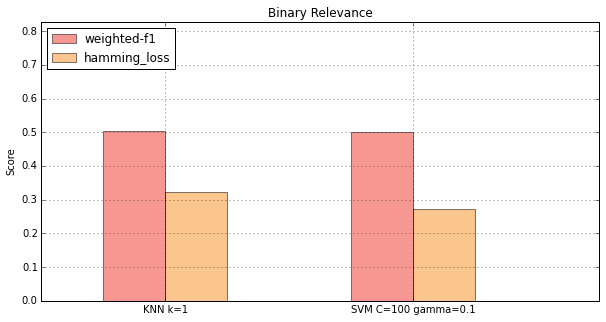

In [59]:
plot_comparison('Binary Relevance')

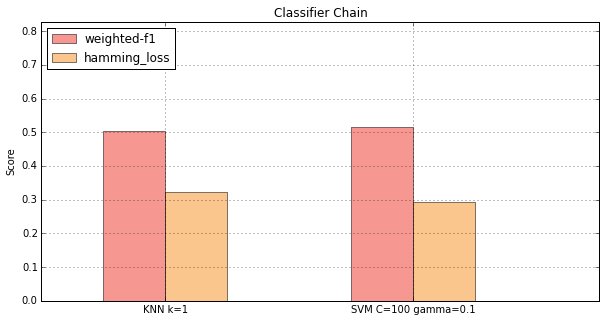

In [60]:
plot_comparison('Classifier Chain')

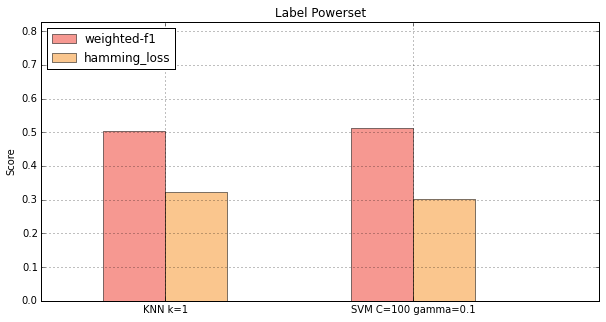

In [61]:
plot_comparison('Label Powerset')

#### 2. Compare Strategies (Binary Relevance, Classifier Chain, Label Powerset)

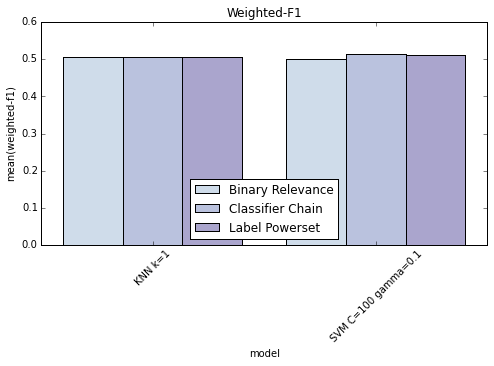

In [101]:
metric_plot_df = metric_df[(metric_df['train_test']== 'test')]
fig, ax = plt.subplots(1, 1, figsize=(8,4))
sns.set_palette(sns.cubehelix_palette(8,start=1, rot=-.5))
ax = sns.barplot(x="model", y="weighted-f1", hue="strategy", data=metric_plot_df)
xt = plt.xticks(rotation=45)
ax.set_title("Weighted-F1")
plt.legend(loc='best')
plt.show()

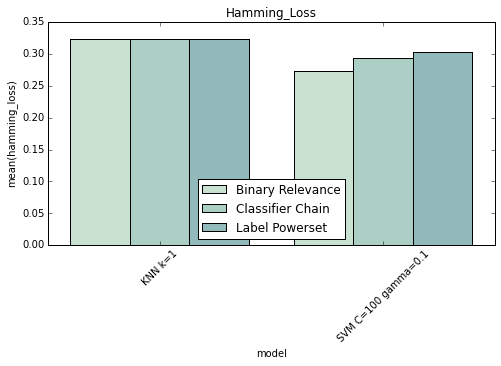

In [100]:
metric_plot_df = metric_df[(metric_df['train_test']== 'test')]
fig, ax = plt.subplots(1, 1, figsize=(8,4))
sns.set_palette(sns.cubehelix_palette(10,start=1, rot=-.75))
ax = sns.barplot(x="model", y="hamming_loss", hue="strategy", data=metric_plot_df)
xt = plt.xticks(rotation=45)
ax.set_title("Hamming_Loss")
plt.legend(loc='best')
plt.show()

# Results and Discussion

## Goal

1. We examine the performance metric for the test set among various classifiers.
    - For hamming loss, the smaller the value , the smaller the difference between predicted and true labels.

    - For F1 score, the larger the value , the smaller the difference between predicted and true labels. We will focus on weighted F1 score for now.

2. We examine the performance metric for each strategy :Binary Relevance,Classifier Chain,Label Powerset.

3. We will look into the performance metric for labels with more movies vs labels with fewer moviews.
    - We can examine the difference between F1 score for macro average and micro average. If the micro-average result is significantly lower than the macro-average one, it means that we have some gross misclassification in the most populated labels, whereas our smaller labels are probably correctly classified. 
    
4. We examine if cross-validation by kfold has similiar result as by stratified kfold
    - k-folding may lead to severe problems with label combination representability across folds, thus if the data exhibits a strong label co-occurrence structure,  using a label-combination based stratified k-fold will be better.
    

## 1.  Classifier with the best metric
After comparing KNN and SVM based on weighted-f1 and hamming_loss, we found out the **SVM** has lower hamming_loss scores for all 3 strategies, and weighted-f1 for both classifier are similiar. The performances of KNN and SVM does not differ much. Generally, **SVM** is better. As we only tuned limited set of parameters for SVM here, we may need to re-do the parameter tuning on whole dataset to get more accurate results.

## 2.  Strategy with the best metric
For **KNN**, three strategies have same performance for both weighted-f1 and hamming_loss metrics <br>
For **SVM**, Binary Relevance has lowest hamming_loss score and Classifier Chain has highest weighted-f1 score. <br>
In general, **Binary Relevance** and **Classifier Chain** have better performance on our models.

## 3.  If the best method we pick favor any label of size differences
XXXXXXXXXxx